## Week 2 Pathfinding

This notebook implements a pathfinding algorithm which finds the best path given a map of asteroids and minshara plantes. 

In [17]:
# first we import the libraries we need
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

import time

### Defining functions

In [56]:
# Function that generates random asteroids
def generate_asteroids(minshara = False):
    # Customise the length of the field
    length = 20
    asteroids = []
    minsharas = []

    for i in range(1, length):
        possible_ys = [j for j in range(-4, 5, 1)]
        if np.random.uniform() > 0.2:
            new = possible_ys.pop(np.random.choice(possible_ys))
            asteroids.append([i, new])
            if np.random.uniform() > 0.5:
                new = possible_ys.pop(np.random.choice(possible_ys))
                asteroids.append([i, new])
        if minshara and np.random.uniform() > 0.5:
            new = possible_ys.pop(np.random.choice(possible_ys))
            minsharas.append([i, new])
    
    return asteroids, minsharas

asteroids, minsharas = generate_asteroids()

In [19]:
# Function that generates a map given asteroids and minsharas
def generate_map(asteroid_locations, minshara_locations = None):
    if minshara_locations:
        all_locations = np.concatenate((asteroid_locations, minshara_locations), axis=0)
    else:
        all_locations = asteroid_locations
    max_up = int(max(all_locations, key=lambda x: x[1])[1])
    max_down = int(min(all_locations, key=lambda x: x[1])[1])
    start = -max_down + 1
    height = max_up - max_down + 3
    length = int(max(all_locations, key=lambda x: x[0])[0]) + 3
    
    map = np.zeros((length, height))
    for location in asteroid_locations :
        map[int(location[0])][int(location[1]) - max_down + 1] = -100
    if minshara_locations:
        for location in minshara_locations :
            map[int(location[0])][int(location[1]) - max_down + 1] = -50

    map[0][-max_down + 1] = 1

    return map, length-1, height, start

In [20]:
# Function that generates graph representing the distances and connections between positions
def generate_graph(map, height, length, start):
    grid = [[0 for x in range(height * length + 1)] for y in range(height * length + 1)]

    # distances from initial position
    for coordinate_next in range(0, height):
        # Find the coordinates of the asteroids in this and next column
        asteroid_next_ys = [int(location) for location in range(len(map[1])) if map[1][location] == -100]
        asteroid_current_ys = [int(location) for location in range(len(map[0])) if map[0][location] == -100]
        if coordinate_next not in asteroid_next_ys:
            if coordinate_next == start:
                grid[0][coordinate_next+1] = 1
            
            available = True
            for asteroid in asteroid_next_ys:
                if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                    if np.absolute(asteroid - coordinate_next)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                        available = False
            
            for asteroid in asteroid_current_ys:
                if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                    if np.absolute(asteroid - start)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                        available = False          
                    
            if available:
                if map[1][coordinate_next] == -50:
                    grid[0][coordinate_next+1] = np.sqrt((start - coordinate_next)**2 + 1) - 50
                else:
                    grid[0][coordinate_next+1] = np.sqrt((start - coordinate_next)**2 + 1)
                        
    # distances from other positions
    for current_time in range(1, length):
        for start in range(0, height):
            for coordinate_next in range(0, height):
                # Find the coordinates of the asteroids in this and next column
                asteroid_next_ys = [int(location) for location in range(len(map[current_time+1])) if map[current_time+1][location] == -100]
                asteroid_current_ys = [int(location) for location in range(len(map[current_time])) if map[current_time][location] == -100]
                if coordinate_next not in asteroid_next_ys:
                    if coordinate_next == start:
                        grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = 1
                    
                    available = True
                    for asteroid in asteroid_next_ys:
                        if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                            if np.absolute(asteroid - coordinate_next)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                                available = False
                    
                    for asteroid in asteroid_current_ys:
                        if (asteroid > coordinate_next and asteroid < start) or (asteroid < coordinate_next and asteroid > start):
                            if np.absolute(asteroid - start)/np.sqrt((start - coordinate_next)**2 + 1) <= 0.5:
                                available = False    
                            
                    if available:
                        if map[current_time+1][coordinate_next] == -50:
                            grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = np.sqrt((start - coordinate_next)**2 + 1) - 50
                        else:
                            grid[1+(current_time-1)*height+start][coordinate_next+1+height*current_time] = np.sqrt((start - coordinate_next)**2 + 1)
                    
    return grid

In [21]:
# Function that generates the path to follow
def generate_path(asteroid_locations, minshara_locations = None):
    map, length, height, start_initially = generate_map(asteroid_locations, minshara_locations)
    start_time = time.time()
    grid = generate_graph(map, height, length, start_initially)
    end_time = time.time()

    print("Time taken to generate graph: ", end_time - start_time)

    graph = csr_matrix(grid)

    start_time = time.time()
    _, predecessors = shortest_path(csgraph=graph, directed=True, method='BF', indices=0, return_predecessors=True)

    index_end = len(grid[0]) - height + start_initially
    path = [index_end % height - 1 - start_initially]

    while predecessors[index_end] != -9999:
        next_index = predecessors[index_end] % height - 1 - start_initially
        if predecessors[index_end] % height == 0:
            next_index = height - 1 - start_initially
        path.append(next_index)
        index_end = predecessors[index_end]

    path.reverse()
    path[0] = 0

    end_time = time.time()
    print("Time taken to find path: ", end_time - start_time)

    return path

In [22]:
# Finction to find distance of path
def get_distance(path):
    distance = 0
    for i in range(1, len(path)):
        distance += np.sqrt((path[i] - path[i-1])**2 + 1)
    return distance

In [23]:
# Function to plot map and path given asteroid and minshara locations
def plot_map_and_path(ax,asteroid_locations, minshara_locations = None) :
    _, length, height, start = generate_map(asteroid_locations, minshara_locations)
    path = generate_path(asteroid_locations, minshara_locations)

    print("Path taken: ", path)

    plt.axis([0, length, -start-0.5, height - start - 0.5])
    major_ticks_xs = np.arange(0, length, 1)
    major_ticks_ys = np.arange(-start, height - start, 1)
    ax.set_xticks(major_ticks_xs)
    ax.set_yticks(major_ticks_ys)
    plt.xlabel("time / x position")
    plt.ylabel("position")
    ax.set_aspect('equal')
    ax.grid(which='major', alpha=0.8)

    for location in asteroid_locations :
        circle=plt.Circle(location, 0.5 , color='r')
        ax.add_artist(circle)

    if minshara_locations is not None:
        for location in minshara_locations :
            circle=plt.Circle(location, 0.5 , color='b')
            ax.add_artist(circle)

    list_of_times = np.arange(0, length+1, 1)
    
    # go through the list of times, where index is the index within the 
    # list, and time_now is the entry at that index
    for index, time_now in enumerate(list_of_times) :
        position_now = path[index]
        ax.plot(time_now, position_now, 'o')

    ax.plot(list_of_times, path, 'g-')

    print("Distance travelled: ", get_distance(path))

### Plotting a random map and the best path

Time taken to generate graph:  0.02031850814819336
Time taken to find path:  0.0010030269622802734
Path taken:  [0, 0, 1, 2, 4, -1, -2, -2, -2, -2, -2, -3, -4, -4, -3, -2, -1, 0, 1, 0, 0, 0]
Distance travelled:  30.891436677196626


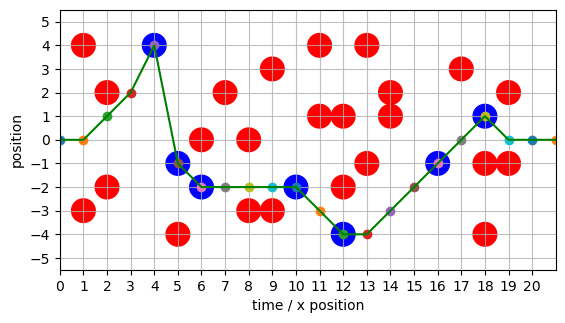

In [66]:
# Generate random asteroids and minsharas
random_asteroids, random_minsharas = generate_asteroids(minshara = True)

# Plot map and path
fig = plt.figure()
ax = plt.gcf().gca()
plot_map_and_path(ax, random_asteroids, random_minsharas)